In [1]:
import cv2
import os
import random

from register_dataset import *
from detectron2.engine import DefaultPredictor, default_setup
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.config import get_cfg
from detectron2 import model_zoo

import matplotlib.pyplot as plt
def cv2_imshow(x, title=None):
    plt.imshow(x[...,::-1])
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



# Registered Dataset
+ cocotrain2014, cocoval2014, 
+ Shiptrainval, Shiptest, 
+ Ship_Part1trainval, Ship_Part1test, 
+ SSDDtrainval, SSDDtest, 
+ VOC2007trainval, VOC2007test, 
+ AIR-SARShip-1.0trainval, AIR-SARShip-1.0test, 
+ AIR-SARShip-2.0trainval, AIR-SARShip-2.0test, 
+ HRSIDtrain2017, HRSIDtest2017, HRSIDtrain_test2017

In [2]:
dataset_name_train = "SSDDtrainval"
dataset_name_test = "SSDDtest"
dataset_metadata = MetadataCatalog.get(dataset_name_train)
dataset_dicts = DatasetCatalog.get(dataset_name_train)

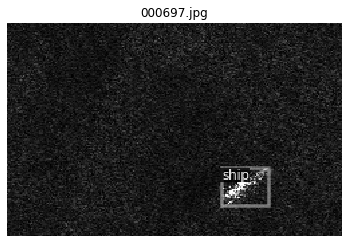

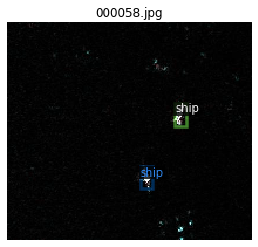

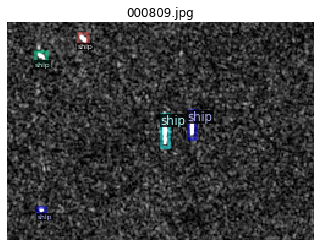

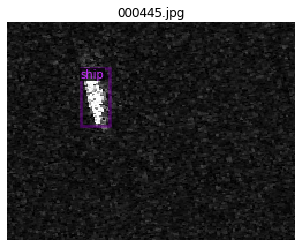

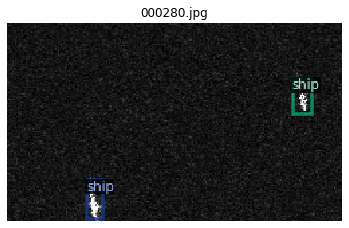

In [3]:
nr_of_samples = 5
scale = 0.5
for d in random.sample(dataset_dicts, nr_of_samples):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[..., ::-1], metadata=dataset_metadata, scale=scale)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image(), title=os.path.split(d["file_name"])[1])

# Load model

In [4]:
def setup(config_file):
    """
    Create configs and perform basic setups.
    """
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml") 
    cfg.merge_from_file(config_file)
    default_setup(cfg, None)
    return cfg

In [5]:
# cfg already contains everything we've set previously. Now we changed it a little bit for inference:
cfg = setup(config_file='yamls/SSDD/Faster-RCNN-R50.yaml' )
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
predictor = DefaultPredictor(cfg)

[01/24 03:06:50 detectron2]: Rank of current process: 0. World size: 1
[01/24 03:06:50 detectron2]: Environment info:
----------------------  -------------------------------------------------------------------
sys.platform            linux
Python                  3.7.3 (default, Mar 27 2019, 22:11:17) [GCC 7.3.0]
numpy                   1.18.5
detectron2              0.3 @/home/jtli/anaconda3/lib/python3.7/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 10.1
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.6.0 @/home/jtli/anaconda3/lib/python3.7/site-packages/torch
PyTorch debug build     False
GPU available           True
GPU 0,1                 GeForce RTX 2080 Ti (arch=7.5)
CUDA_HOME               /usr/local/cuda
Pillow                  7.2.0
torchvision             0.7.0 @/home/jtli/anaconda3/lib/python3.7/site-packages/torchvision
torchvision arch flags  3.5, 5.0, 6.0, 7.0, 7

# Visualization

/home/jtli/anaconda3/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  filter_inds = filter_mask.nonzero()


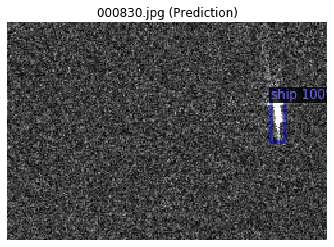

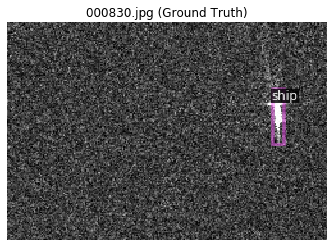

##################################################


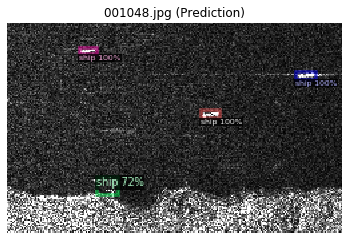

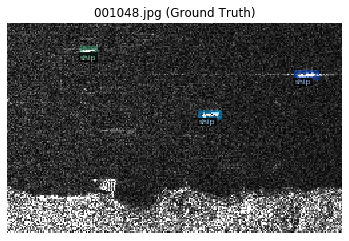

##################################################


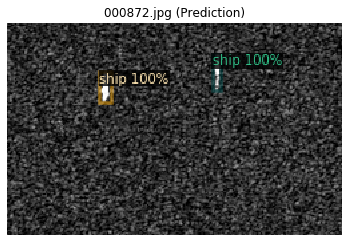

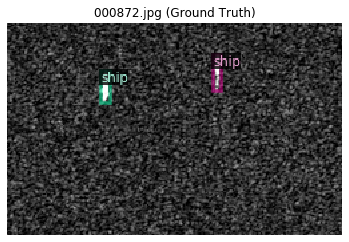

##################################################


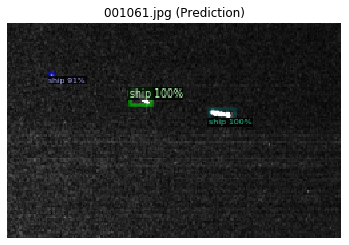

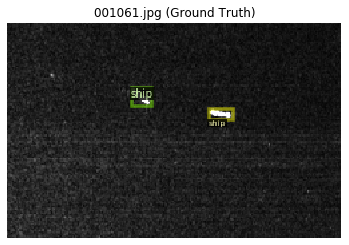

##################################################


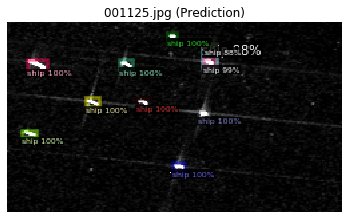

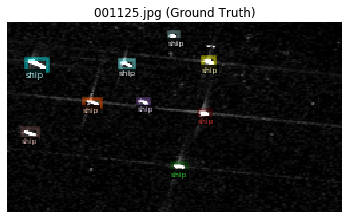

##################################################


In [6]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = DatasetCatalog.get(dataset_name_test)
dataset_metadata = MetadataCatalog.get(dataset_name_test)

for d in random.sample(dataset_dicts, nr_of_samples):
    im = cv2.imread(d["file_name"])
    name = os.path.split(d["file_name"])[1]
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v1 = Visualizer(im[..., ::-1],
                   metadata=dataset_metadata,
                   scale=scale, 
    )
    out = v1.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image(), title=f"{name} (Prediction)")
    
    v2 = Visualizer(im[..., ::-1], metadata=dataset_metadata, scale=scale)
    out = v2.draw_dataset_dict(d)
    cv2_imshow(out.get_image(), title=f"{name} (Ground Truth)")
    print("#"*50)